In [1]:
from src.util import DataLoader, AortaNormalizer
from src.visualiazation import plot_pca

import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

**Load Data**

In [2]:
data_path = "../../../data/PulHypStudie_Check_npz_v2/"

In [3]:
data_list = [i for i in range(1, 10)]  # (1,11)-> all pigs
data_list  # pig 10 -> test pig

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
data_loader = DataLoader(data_path)

Eit, Y, Pig = data_loader.load_data(data_list)

Data path: ../../../data/PulHypStudie_Check_npz_v2/ contains 10 pigs:
⋅ P_01_PulHyp
⋅ P_02_PulHyp
⋅ P_03_PulHyp
⋅ P_04_PulHyp
⋅ P_05_PulHyp
⋅ P_06_PulHyp
⋅ P_07_PulHyp
⋅ P_08_PulHyp
⋅ P_09_PulHyp
⋅ P_10_PulHyp
Got a list of 9 pigs to load.
To load ['P_01_PulHyp' 'P_02_PulHyp' 'P_03_PulHyp' 'P_04_PulHyp' 'P_05_PulHyp'
 'P_06_PulHyp' 'P_07_PulHyp' 'P_08_PulHyp' 'P_09_PulHyp']
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_01_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_02_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_03_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_04_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_05_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_06_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_07_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_08_PulHyp
Loading data from ../../../data/PulHypStudie_Check_npz_v2/P_09_

In [5]:
aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y)
Y_true = Y[:, :, 0]

assert np.allclose(Y_true, aorta_normalizer.normalize_inverse(Y_norm)[:, :, 0])

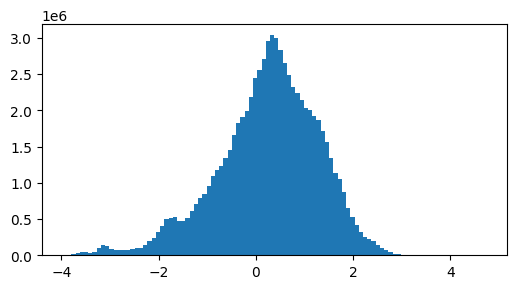

0.2559536422850982
1.0891120210120573


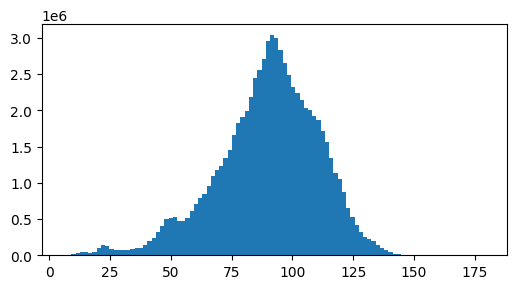

90.11907284570236
435.6448084048207


In [6]:
plt.figure(figsize=(6, 3))
plt.hist(Y_norm.flatten(), bins=100)
plt.show()
print(np.mean(Y_norm.flatten()))
print(np.var(Y_norm.flatten()))

plt.figure(figsize=(6, 3))
plt.hist(Y_true.flatten(), bins=100)
plt.show()
print(np.mean(Y_true.flatten()))
print(np.var(Y_true.flatten()))

**VAE** - HPT

In [7]:
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    Conv1D,
    ZeroPadding1D,
    Reshape,
    Cropping1D,
)
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean


class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss, reconstruction_loss, kl_loss = self.vae_loss(
                data, reconstruction, z_mean, z_log_var
            )

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        loss, reconstruction_loss, kl_loss = self.vae_loss(
            data, reconstruction, z_mean, z_log_var
        )

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        mse_loss_fn = MeanSquaredError()
        input_dim = 1024
        reconstruction_loss = mse_loss_fn(inputs, outputs) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss


# The encoder model
def encoder_model(
    input_shape=(1024, 1),
    channels=(5, 10, 20, 30),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
    latent_dim=8,
):
    encoder_inputs = Input(shape=input_shape)
    x = encoder_inputs

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


# The decoder model
def decoder_model(
    latent_dim=8,
    channels=(30, 20, 10, 5),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
):
    latent_inputs = Input(shape=(latent_dim,))
    L = (1024 // np.prod(strides)) * channels[0]
    x = Dense(L, activation="elu")(latent_inputs)
    x = Reshape((1024 // np.prod(strides), channels[0]))(x)

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1DTranspose(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Conv1DTranspose(1, 1, activation="elu", padding="same")(x)
    decoded = x

    return latent_inputs, decoded

2024-12-03 10:35:05.347091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 10:35:05.955699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
def build_vae_model(hp):
    latent_dim = hp.Int("latent_dim", min_value=4, max_value=16, step=4)
    beta = hp.Float("beta", min_value=0.8, max_value=2.0, step=0.1)
    # num_channels_choice = hp.Choice("num_channels", values=[5, 10, 20, 30])
    kernel_size = hp.Int("kernel_size", min_value=3, max_value=15, step=1)
    strides = hp.Int("strides", min_value=2, max_value=4, step=1)

    channels = (5, 10, 20, 30)
    # kernel_sizes=(5, 5, 5, 5)
    kernel_sizes = [kernel_size] * 4
    # strides=(4, 4, 4, 4)
    stride_sizes = [strides] * 4

    # Build encoder and decoder
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        channels=channels,
        kernel_size=kernel_sizes,
        strides=stride_sizes,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="Encoder")

    decoder_inputs, decoder_outputs = decoder_model(
        channels=channels[::-1],
        kernel_size=kernel_sizes[::-1],
        strides=stride_sizes[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="Decoder")

    encoder.summary()
    decoder.summary()
    vae = VAE(encoder, decoder, beta=beta)

    vae.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5])
        )
    )
    return vae

In [9]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_vae_model,
    objective="loss",
    max_epochs=20,
    factor=2,
    directory="vae_hpt",
    project_name="vae_tuning_2",
)

# Perform hyperparameter search
tuner.search(Y_norm, epochs=10, validation_split=0.1, batch_size=16)

Trial 51 Complete [00h 00m 05s]

Best loss So Far: 114.75859832763672
Total elapsed time: 01h 11m 32s

Search: Running Trial #52

Value             |Best Value So Far |Hyperparameter
8                 |4                 |latent_dim
1.1               |0.8               |beta
3                 |9                 |kernel_size
3                 |2                 |strides
0.001             |0.0001            |lr
5                 |5                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 5)   │         20 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 5)   │         20 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024, 5)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 342, 5)    │         80 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 342, 5)    │         20 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 342, 5)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 342, 10)   │        160 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 342, 10)   │         40 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 342, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 114, 10)   │        310 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 114, 10)   │         40 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 114, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 114, 20)   │        620 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 114, 20)   │         80 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 114, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 38, 20)    │      1,220 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 20)    │         80 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 38, 20)    │          0 │ batch_normalizat

 Total params: 13,746 (53.70 KB)

 Trainable params: 13,486 (52.68 KB)

 Non-trainable params: 260 (1.02 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 360)            │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 36, 30)         │         2,730 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 36, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 36, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 36, 30)         │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 36, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 36, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 108, 20)        │         1,820 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 108, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 108, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 108, 20)        │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 108, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 108, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 324, 10)        │           610 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 324, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 324, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 324, 10)        │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 324, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,421 (52.43 KB)

 Trainable params: 13,161 (51.41 KB)

 Non-trainable params: 260 (1.02 KB)

Epoch 1/5


Traceback (most recent call last):
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/ipykernel_630687/3033822993.py", line 53, in train_step
    loss, reconstruction_loss, kl_loss = self.vae_loss(
  File "/tmp/ipykernel_630687/3033822993.py", line 95, in vae_loss
    reconstruction_loss = mse_loss_fn(inputs, outputs) * input_dim
ValueError: Dimensions must be equal, but are 1024 and 972 for '{{node mean_squared_error/sub}} = Sub[T=DT_FLOAT](data, Decoder_1/conv1d_transpose_4_1/Elu)' with input shapes: [?,1024,1], [?,972,1].


In [10]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [11]:
best_hps.values

{'latent_dim': 4,
 'beta': 0.8,
 'kernel_size': 9,
 'strides': 2,
 'lr': 0.0001,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [12]:
vae = tuner.hypermodel.build(best_hps)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1024, 5)   │         50 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 5)   │         20 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 1024, 5)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 512, 5)    │        230 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 5)    │         20 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 512, 5)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 512, 10)   │        460 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 10)   │         40 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 512, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 256, 10)   │        910 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 10)   │         40 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 256, 20)   │      1,820 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 20)   │         80 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 128, 20)   │      3,620 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 20)   │         80 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 20)   │          0 │ batch_normalizat

 Total params: 36,538 (142.73 KB)

 Trainable params: 36,278 (141.71 KB)

 Non-trainable params: 260 (1.02 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1920)           │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 128, 30)        │         8,130 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 128, 30)        │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 128, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 256, 20)        │         5,420 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 256, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 256, 20)        │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 256, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 512, 10)        │         1,810 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 512, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 512, 10)        │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 38,831 (151.68 KB)

 Trainable params: 38,571 (150.67 KB)

 Non-trainable params: 260 (1.02 KB)

**Train hpt model**

In [13]:
# vae.encoder.summary()
# vae.decoder.summary()

In [14]:
from glob import glob

In [23]:
# vae = vae_model(beta=0.98)
vae.compile(
    optimizer=tf.keras.optimizers.Adam()
)  # , loss=tf.keras.losses.MeanSquaredError()

vae.summary()

history_vae = vae.fit(
    Y_norm,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
)

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder (Functional)            │ ?                      │         9,426 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ ?                      │        11,261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,687 (80.81 KB)

 Trainable params: 20,167 (78.78 KB)

 Non-trainable params: 520 (2.03 KB)

Epoch 1/40
7354/7354 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - kl_loss: 23.1952 - loss: 145.6202 - reconstruction_loss: 140.9812 - val_kl_loss: 14.4552 - val_loss: 107.7310 - val_reconstruction_loss: 104.8400
Epoch 2/40
7354/7354 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - kl_loss: 13.3679 - loss: 100.5207 - reconstruction_loss: 97.8470 - val_kl_loss: 11.3980 - val_loss: 105.5552 - val_reconstruction_loss: 103.2756
Epoch 3/40
7354/7354 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - kl_loss: 11.4482 - loss: 104.4492 - reconstruction_loss: 102.1597 - val_kl_loss: 10.5147 - val_loss: 106.6635 - val_reconstruction_loss: 104.5606
Epoch 4/40
7354/7354 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - kl_loss: 10.4674 - loss: 97.9525 - reconstruction_loss: 95.8589 - val_kl_loss: 10.3543 - val_loss: 105.1681 - val_reconstruction_loss: 103.0973
Epoch 5/40
7354/7354 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - kl_loss: 10.3274 - loss: 98.6581 - reconstruction_loss: 96.5926 - val_kl_loss: 11.0932 - val_loss: 105.2806 - val_reconstruction_loss:

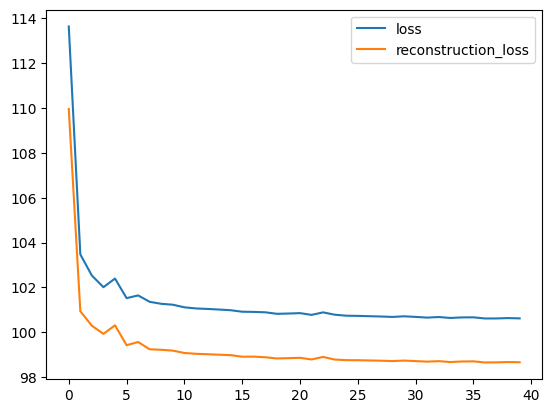

In [24]:
plt.plot(history_vae.history["loss"], label="loss")
plt.plot(history_vae.history["reconstruction_loss"], label="reconstruction_loss")
plt.legend()
# plt.savefig(f"model/loss_{int(beta*100)}.png")
plt.plot()
plt.show()

In [27]:
s_idx_num = len(glob("src/weights/vae*.weights.h5"))
vae.save_weights(f"src/weights/vae_model_excl_10_{s_idx_num}.weights.h5")
np.savez(f"src/weights/vae_model_excl_10_{s_idx_num}.npz", loss=history_vae)

In [31]:
print(f"Saved as src/weights/vae_model_excl_10_{s_idx_num}.weights.h5")

Saved as src/weights/vae_model_excl_10_2.weights.h5


**VAE test**

In [32]:
_, _, z_space = vae.encoder.predict(Y_norm)

2298/2298 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step


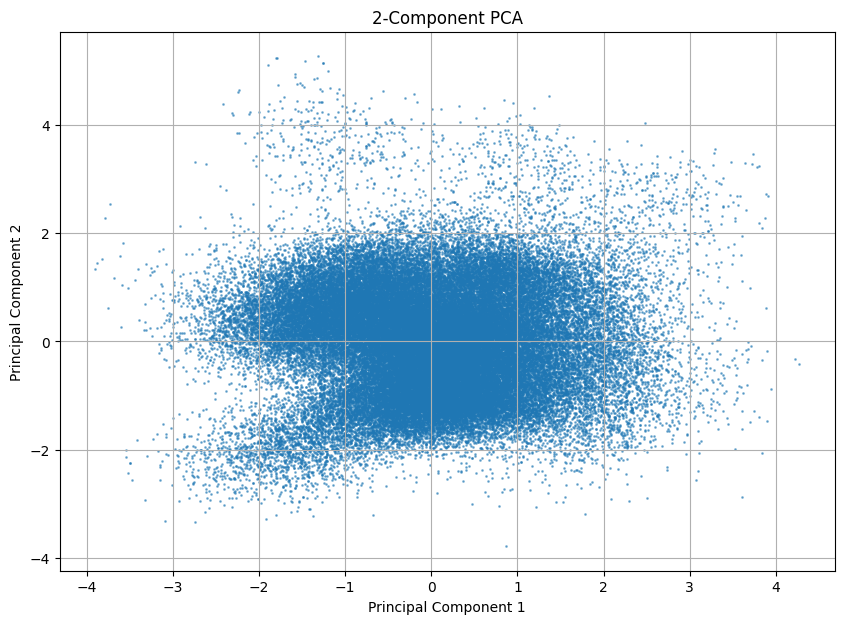

In [33]:
plot_pca(z_space)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


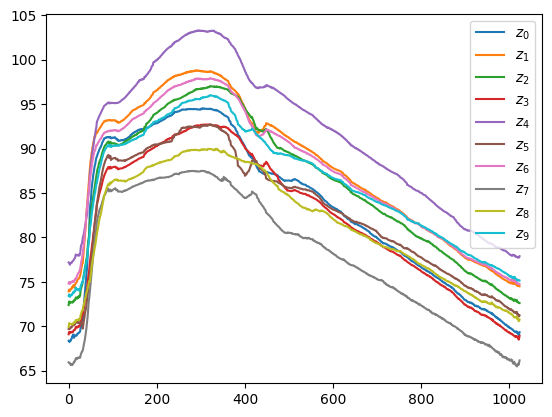

In [37]:
z = np.random.random(size=(10, 8))
Aorta_pred = vae.decoder.predict(z)

for i in range(10):
    plt.plot(aorta_normalizer.normalize_inverse(Aorta_pred)[i, :, 0], label=f"$z_{i}$")
plt.legend()
plt.show()